In [16]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep=';')

data = data[data['total sulfur dioxide']<200]

cols_to_z_score = data.keys()
cols_to_z_score = cols_to_z_score.drop('residual sugar')

# for col in cols_to_z_score:
#     meanval = np.mean(data[col])
#     stdev = np.std(data[col], ddof=0)
#     data[col] = (data[col]-meanval) / stdev
data[cols_to_z_score] = data[cols_to_z_score].apply(stats.zscore)   


In [18]:
dataT = torch.tensor(data[cols_to_z_score].values).float()
labels = torch.tensor(data['residual sugar'].values).float()

labels = labels[:, None]

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=.1)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [19]:
def create_model():
    VINEiris = nn.Sequential(
    nn.Linear(11, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    )
    
    loss_fun = nn.MSELoss()
    optimizer = torch.optim.SGD(VINEiris.parameters(), lr=.01)
    
    return VINEiris, loss_fun, optimizer

In [20]:
num_of_epochs = 1000

def train_model(model, loss_func, optimizer):
    train_losses = []
    test_losses = []
    
    for epoch in range(num_of_epochs):
        model.train()
        batch_train_loss = []
        for X, y in train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_train_loss.append(loss.item())
            
        train_losses.append(np.mean(batch_train_loss))
        
        model.eval()
        X,y = next(iter(test_loader))
        yHat = model(X)
        test_losses.append((yHat-y).pow(2).mean().item())
    
    return train_losses, test_losses

In [21]:
model, loss_func, optimizer = create_model()

train_losses, test_losses = train_model(model, loss_func, optimizer)

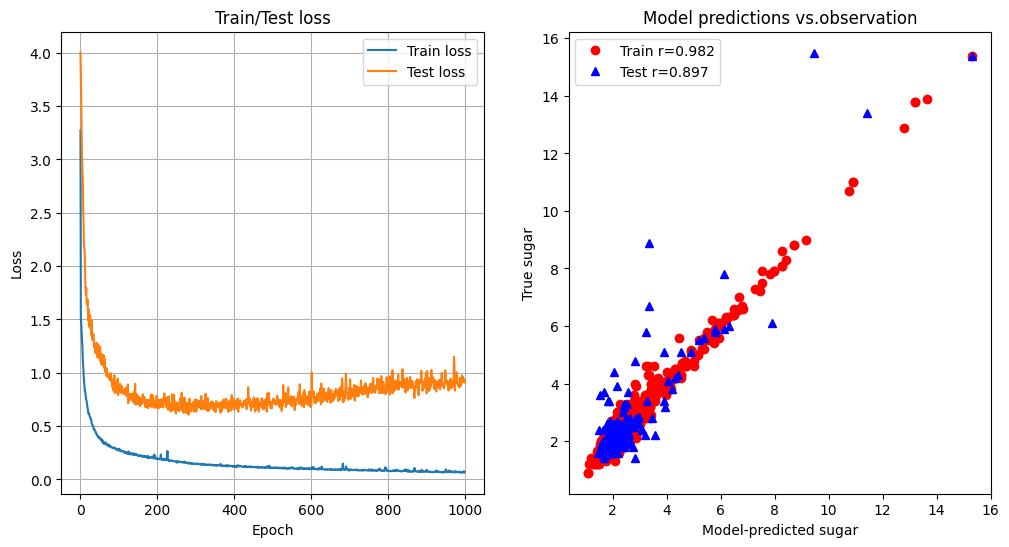

In [23]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].plot(train_losses, label='Train loss')
ax[0].plot(test_losses, label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()

y_hat_train = model(train_data)
y_hat_test = model(test_data)
ax[1].plot(y_hat_train.detach(), train_labels, 'ro')
ax[1].plot(y_hat_test.detach(), test_labels, 'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs.observation')

corr_train = np.corrcoef(y_hat_train.detach().T, train_labels.T)[1,0]
corr_test = np.corrcoef(y_hat_test.detach().T, test_labels.T)[1,0]
ax[1].legend([f"Train r={corr_train:.3f}", f"Test r={corr_test:.3f}"])

plt.show()

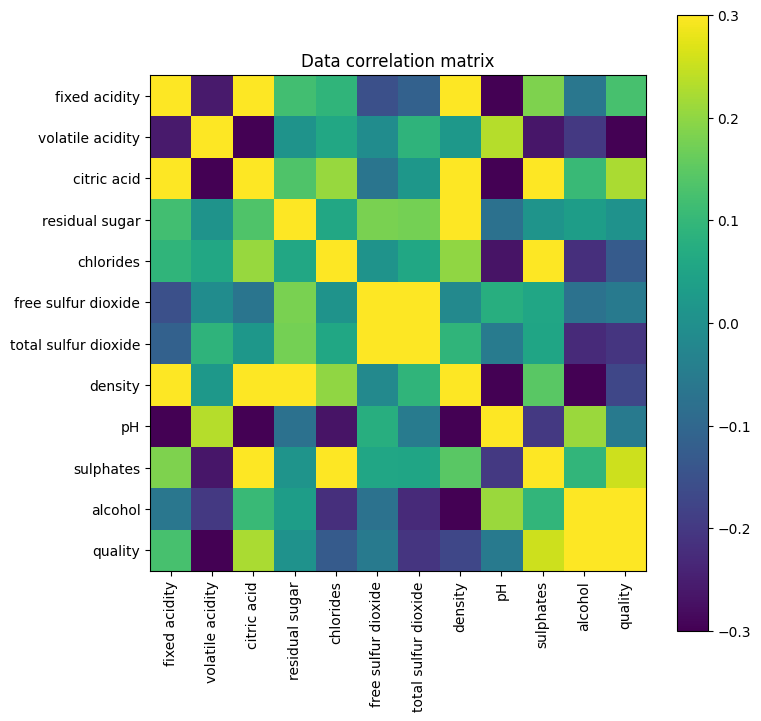

In [25]:
fig = plt.figure(figsize=(8,8))
plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())), labels=data.keys(), rotation=90)
plt.yticks(range(len(data.keys())), labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()